# 1)  데이터 전처리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
mpl.rc('font', family="Malgun Gothic")

from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler 
from sklearn.model_selection import train_test_split

In [2]:
def preprocessing(df_scaling, scaled_form = 'MinMaxScaler()'):
    # 불필요한 컬럼 제거
    if 'ID' in df_scaling:
        df_scaling = df_scaling.drop("ID", axis = 1)
        if len(df_scaling.columns) == 1:
            return df_scaling
        
        df_scaling = df_scaling.drop('oral', axis = 1) 
        # 범주형 피처 레이블 인코딩 
        cate_features = df_scaling[['gender','tartar']]

        lbe = LabelEncoder()
        lbe.fit_transform(df_scaling["gender"])
        df_scaling["gender"] = lbe.fit_transform(df_scaling["gender"])

        lbe = LabelEncoder()
        lbe.fit_transform(df_scaling["tartar"])
        df_scaling["tartar"] = lbe.fit_transform(df_scaling["tartar"])
        
        #3 특성변환 hearing 1,2 -> 0,1
        df_scaling['hearing(left)'] = df_scaling['hearing(left)'].map({2.0 : 1.0 , 1.0 : 0.0})
        
        df_scaling['bmi'] = df_scaling['weight(kg)'] / ((df_scaling['height(cm)']*0.01) **2)
        df_scaling['wwi'] = df_scaling['waist(cm)'] / np.sqrt(df_scaling['weight(kg)'])
        # 시력변환
        df_scaling['eyesight(left)'] = pd.cut(df_scaling['eyesight(left)'] , bins=[0.0,0.9,1.5,2.0,9.9] , labels=[1,2,3,4])
        df_scaling['eyesight(right)'] = pd.cut(df_scaling['eyesight(right)'] , bins=[0.0,0.9,1.5,2.0,9.9] , labels=[1,2,3,4])

        # 정규화 작업
        cate_features = df_scaling[['eyesight(left)','eyesight(right)','gender', 'tartar', 'hearing(right)', 'hearing(left)', 'dental caries']]
        scaled_features = df_scaling.drop(cate_features.columns, axis=1)
        if scaled_form == 'StandardScaler()':
            # Standard scaler
            scaler = StandardScaler()
            scaler.fit(scaled_features)
            scaled = scaler.transform(scaled_features)
            standard_scaled = pd.DataFrame(scaled,columns = scaled_features.columns)
            standard_scaled[cate_features.columns] = cate_features

            return standard_scaled
        else:
            # MinMax scaler
            scaler_M = MinMaxScaler()
            scaler_M.fit(scaled_features)
            scaled_M = scaler_M.transform(scaled_features)
            min_max_scaled = pd.DataFrame(scaled_M,columns = scaled_features.columns)
            min_max_scaled[cate_features.columns] = cate_features

            return min_max_scaled

# 2) 데이터 시각화 및 분석


In [3]:
smoking = pd.read_csv("../data/smoking.csv")
smoking[:1]

,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0


In [4]:
scaled_data = preprocessing(smoking)

In [5]:
scaled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  55692 non-null  float64 
 1   height(cm)           55692 non-null  float64 
 2   weight(kg)           55692 non-null  float64 
 3   waist(cm)            55692 non-null  float64 
 4   systolic             55692 non-null  float64 
 5   relaxation           55692 non-null  float64 
 6   fasting blood sugar  55692 non-null  float64 
 7   Cholesterol          55692 non-null  float64 
 8   triglyceride         55692 non-null  float64 
 9   HDL                  55692 non-null  float64 
 10  LDL                  55692 non-null  float64 
 11  hemoglobin           55692 non-null  float64 
 12  Urine protein        55692 non-null  float64 
 13  serum creatinine     55692 non-null  float64 
 14  AST                  55692 non-null  float64 
 15  ALT                

In [6]:
target = scaled_data['smoking']

In [7]:
x_train , x_test , y_train , y_test = train_test_split(scaled_data , target , train_size=0.9 , random_state=0)

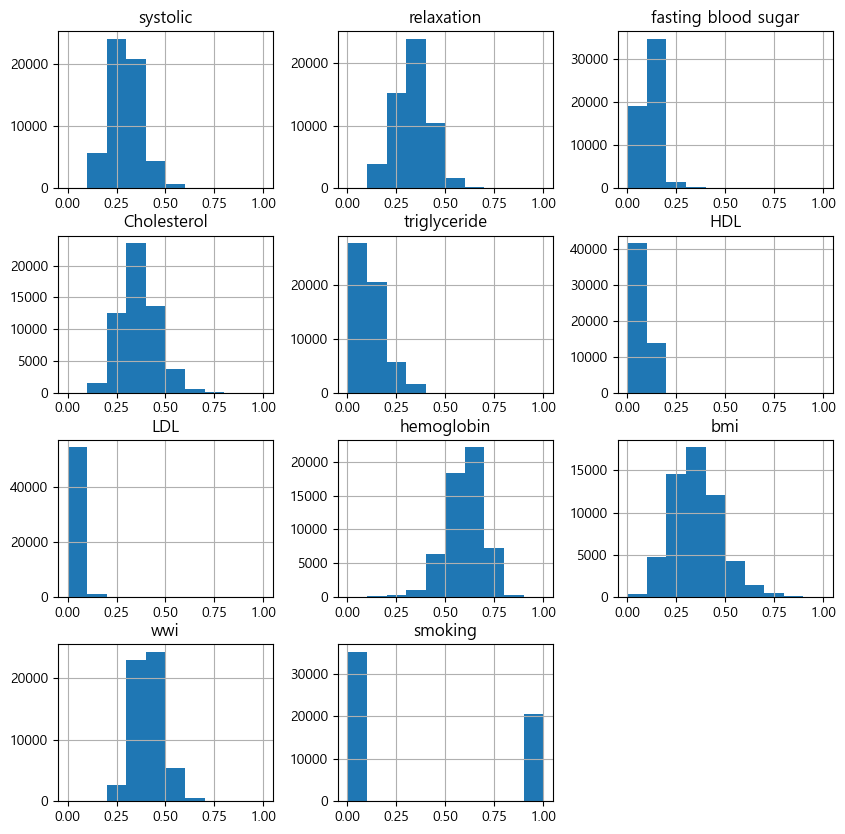

In [9]:
res01 = scaled_data[['systolic' , 'relaxation' , 'fasting blood sugar' , 'Cholesterol' , 'triglyceride' , 
                     'HDL','LDL','hemoglobin','bmi','wwi','smoking']]
res01.hist(figsize=(10,10));

In [10]:
# 상관관계 피어슨 : 계량화(1 ~ -1) , 켄달-타우(순위로 연관성 1 완벽하다)
# 스피어맨(단순순위로) : 계랑화 켄달타우로쓰다가 폭이 너무 극단적이다? 이럼 피어슨으로 바뀜??
# 피어슨 켄달타우 둘중에 뭘써야될지 모르겠다? 스피어맨
#아예 관계가 없는 (피어슨0) 것만 뽑고싶다 피어슨 
res01.corr(method='spearman').style.background_gradient(cmap='magma')

,systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,bmi,wwi,smoking
systolic,1.000000,0.740693,0.224056,0.056849,0.218214,-0.101547,0.022826,0.192769,0.303234,0.151429,0.077256
relaxation,0.740693,1.000000,0.194440,0.095485,0.231156,-0.102325,0.056792,0.234455,0.275957,0.111790,0.109894
fasting blood sugar,0.224056,0.194440,1.000000,0.053751,0.268550,-0.136274,0.010868,0.113347,0.223039,0.185826,0.104440
Cholesterol,0.056849,0.095485,0.053751,1.000000,0.252857,0.156439,0.890150,0.050401,0.103173,0.086524,-0.026374
triglyceride,0.218214,0.231156,0.268550,0.252857,1.000000,-0.469996,0.092784,0.298485,0.351815,0.182760,0.257390
HDL,-0.101547,-0.102325,-0.136274,0.156439,-0.469996,1.000000,-0.058082,-0.274816,-0.341144,-0.133244,-0.195119
LDL,0.022826,0.056792,0.010868,0.890150,0.092784,-0.058082,1.000000,0.057032,0.123839,0.087257,-0.051816
hemoglobin,0.192769,0.234455,0.113347,0.050401,0.298485,-0.274816,0.057032,1.000000,0.273111,-0.076985,0.416544
bmi,0.303234,0.275957,0.223039,0.103173,0.351815,-0.341144,0.123839,0.273111,1.000000,0.204236,0.110766
wwi,0.151429,0.111790,0.185826,0.086524,0.182760,-0.133244,0.087257,-0.076985,0.204236,1.000000,-0.054379


In [11]:
res01.corr().style.background_gradient(cmap='magma')

,systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,bmi,wwi,smoking
systolic,1.000000,0.761051,0.172700,0.059572,0.198826,-0.088487,0.016569,0.186514,0.299640,0.158038,0.073109
relaxation,0.761051,1.000000,0.147879,0.095357,0.215541,-0.089410,0.041017,0.232899,0.280662,0.104793,0.108309
fasting blood sugar,0.172700,0.147879,1.000000,0.009903,0.227746,-0.121274,-0.019615,0.099921,0.171535,0.162957,0.100279
Cholesterol,0.059572,0.095357,0.009903,1.000000,0.247581,0.168623,0.738975,0.061503,0.094269,0.078586,-0.028548
triglyceride,0.198826,0.215541,0.227746,0.247581,1.000000,-0.411752,0.025739,0.273353,0.316197,0.145511,0.251799
HDL,-0.088487,-0.089410,-0.121274,0.168623,-0.411752,1.000000,-0.056398,-0.240095,-0.321877,-0.116368,-0.178470
LDL,0.016569,0.041017,-0.019615,0.738975,0.025739,-0.056398,1.000000,0.052903,0.088781,0.068752,-0.045220
hemoglobin,0.186514,0.232899,0.099921,0.061503,0.273353,-0.240095,0.052903,1.000000,0.254233,-0.070628,0.400678
bmi,0.299640,0.280662,0.171535,0.094269,0.316197,-0.321877,0.088781,0.254233,1.000000,0.204647,0.106967
wwi,0.158038,0.104793,0.162957,0.078586,0.145511,-0.116368,0.068752,-0.070628,0.204647,1.000000,-0.066444


In [29]:
#흡연과 가장 상관관계가 있는건(+) hemoglobin,triglyceride -> 두집단의 t-검증을 생각하자

<AxesSubplot:xlabel='smoking', ylabel='hemoglobin'>

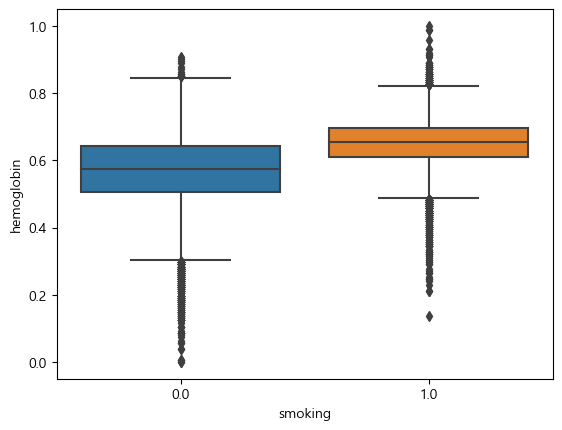

In [30]:
sns.boxplot(data = scaled_data , x='smoking' , y='hemoglobin')
#평가 : 흡연유무가 1 일수록 헤모글로빈이 높아진다 (양의상관관계)

<AxesSubplot:xlabel='smoking', ylabel='triglyceride'>

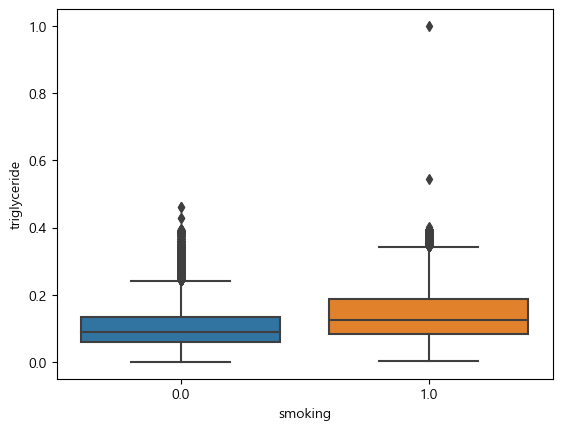

In [31]:
sns.boxplot(data = scaled_data , x='smoking' , y='triglyceride')
#흡연 유무가 1 일수록 트리글리세리드(동맥경화 유발 혈중 지방성분)이 높아진다

<AxesSubplot:xlabel='smoking', ylabel='Cholesterol'>

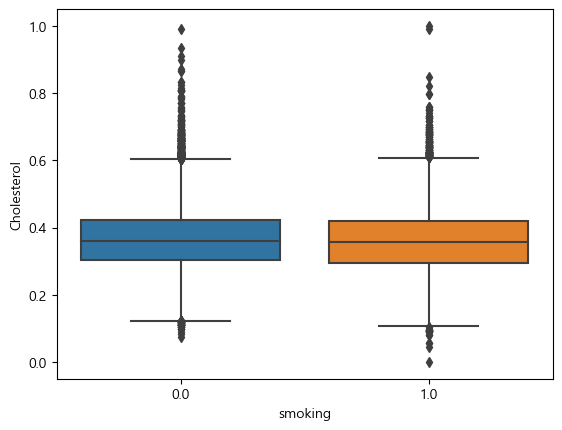

In [12]:
sns.boxplot(data = scaled_data , x='smoking' , y='Cholesterol')
# 흡연 유무와 콜레스테롤의 상관관계는 없다고 보여짐

<AxesSubplot:xlabel='smoking', ylabel='bmi'>

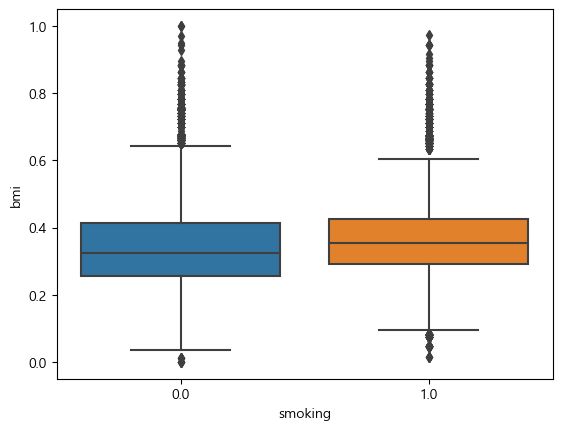

In [32]:
sns.boxplot(data = scaled_data , x='smoking' , y='bmi')
#상관계수 0.11로 분포에 큰차이를 안보임

<AxesSubplot:xlabel='smoking', ylabel='wwi'>

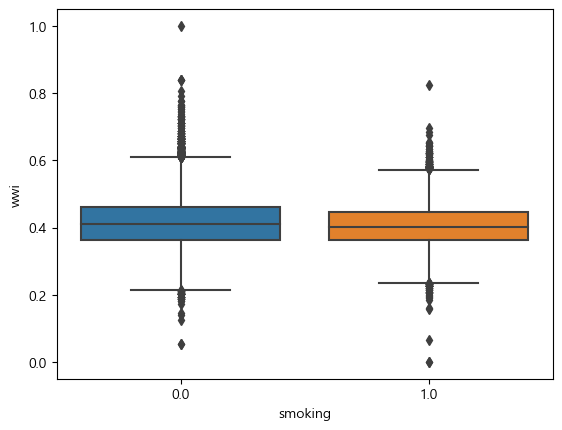

In [33]:
sns.boxplot(data = scaled_data , x='smoking' , y='wwi')

array([[<AxesSubplot:title={'center':'Urine protein'}>,
        <AxesSubplot:title={'center':'serum creatinine'}>],
       [<AxesSubplot:title={'center':'smoking'}>, <AxesSubplot:>]],
      dtype=object)

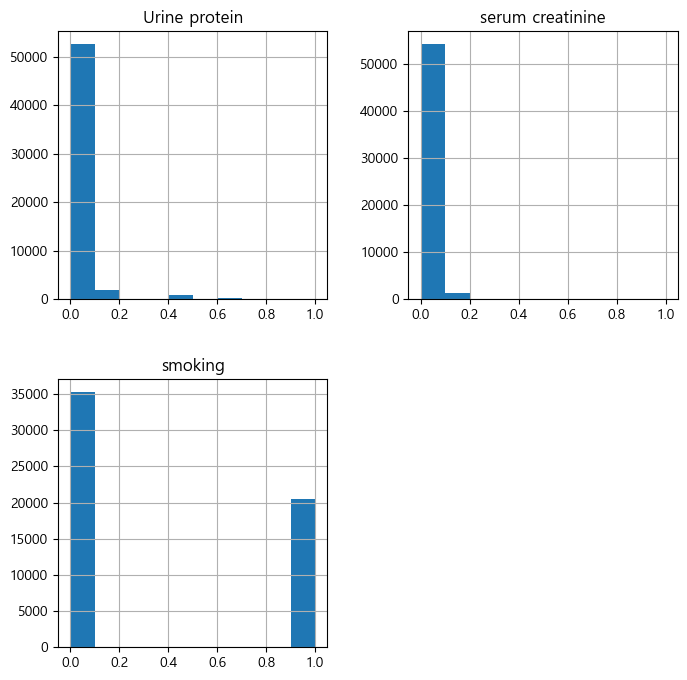

In [46]:
#신장질환
res02 = scaled_data[['Urine protein','serum creatinine' , 'smoking']]
res02.hist(figsize=(8,8))

In [43]:
res02.corr().style.background_gradient(cmap='magma')

,Urine protein,serum creatinine,smoking
Urine protein,1.000000,0.087682,0.014267
serum creatinine,0.087682,1.000000,0.216812
smoking,0.014267,0.216812,1.000000


<AxesSubplot:xlabel='smoking', ylabel='serum creatinine'>

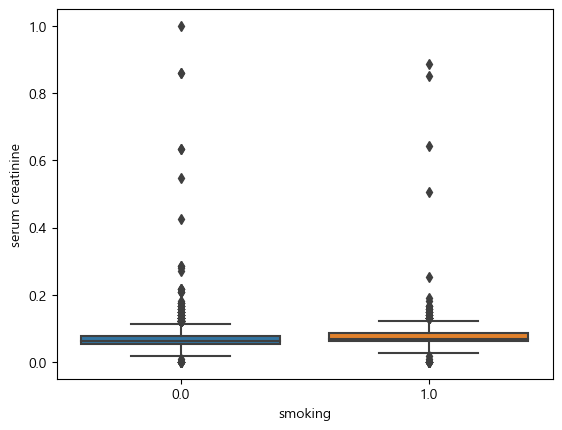

In [44]:
sns.boxplot(data = scaled_data , x='smoking' , y='serum creatinine')
#흡연유무가 1 일수록 y값이 높아짐

In [49]:
#간수치
res03 = scaled_data[['AST','ALT' , 'Gtp' , 'smoking']]
res03.corr().style.background_gradient(cmap='magma')

,AST,ALT,Gtp,smoking
AST,1.000000,0.740726,0.379959,0.059253
ALT,0.740726,1.000000,0.343934,0.097338
Gtp,0.379959,0.343934,1.000000,0.236619
smoking,0.059253,0.097338,0.236619,1.000000


<AxesSubplot:xlabel='smoking', ylabel='Gtp'>

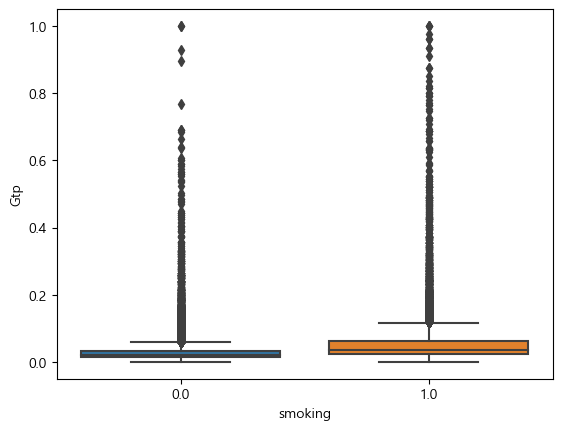

In [51]:
sns.boxplot(data=scaled_data , x = 'smoking' , y = 'Gtp')
#흡연 유무가 1일수록 Gtp(간세포 내 담관에 존재하는 효소, 담즙 배설 장애가 있을 경우 증가하는 경향)가 높아진다

In [38]:
#구강건강
smoke_dental = scaled_data.groupby('smoking')['dental caries'].value_counts(normalize=1)
smoke_dental

smoking  dental caries
0.0      0                0.819082
         1                0.180918
1.0      0                0.730824
         1                0.269176
Name: dental caries, dtype: float64

Text(0.5, 1.0, 'Dental Caries')

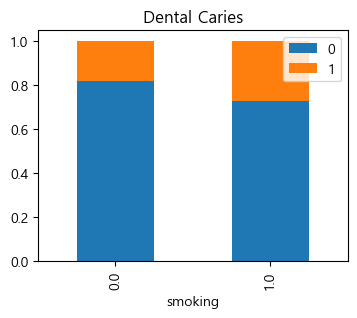

In [37]:
res04 = scaled_data.groupby('smoking')['dental caries'].value_counts(normalize=True).unstack()
res04.plot.bar(stacked = True , figsize=(4,3))
plt.legend(loc = 'upper right')
plt.title('Dental Caries')
#흡연유무가 1일수록 dantal caries(충치)가 증가하는 양상을 보인다

In [64]:
smoke_tartar = scaled_data.groupby('smoking')['tartar'].value_counts(normalize=True)
pd.DataFrame(smoke_tartar)

tartar
smoking tartar          
0.0     1       0.518205
        0       0.481795
1.0     1       0.619897
        0       0.380103

Text(0.5, 1.0, 'tartar')

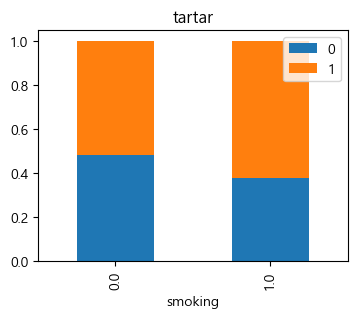

In [14]:
res05 = scaled_data.groupby('smoking')['tartar'].value_counts(normalize=True).unstack()
res05.plot.bar(stacked = True , figsize=(4,3))
plt.legend(loc = 'upper right')
plt.title('tartar')
# 흡연 유무가 1 일수록 tartar(치석)이 증가하는 양상을 보인다